In [1]:
import argparse
import time
from collections import defaultdict
from pathlib import Path

import numpy as np
import requests
import torch
from tqdm import tqdm

import fastmri
import fastmri.data.transforms as T
from fastmri.data import SliceDataset
#from fastmri.models import Unet
# Unet architecture as nn.Module
from run_rss_no_sensmaps.functions.models.unet import Unet

In [2]:
def run_unet_model(batch, model, device):
    image, _, mean, std, fname, slice_num, _ = batch
    output = model(image.to(device).unsqueeze(1)).squeeze(1).cpu()
    mean = mean.unsqueeze(1).unsqueeze(2)
    std = std.unsqueeze(1).unsqueeze(2)
    output = (output * std + mean).cpu()
    return output, int(slice_num[0]), fname[0]

In [3]:
state_dict_file = '/cheng/metaMRI/metaMRI/E001_t1584_l4c64_bs1_lr001_brain/log_files/checkpoints/checkpoint_best.pt'
output_path = Path("/cheng/metaMRI/metaMRI/output/")
device = 'cuda'
model = Unet(in_chans = 1, out_chans = 1, chans = 64,
                num_pool_layers = 4, drop_prob=0.0)
model.load_state_dict(torch.load(state_dict_file), strict=False)
model = model.eval()

RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "down_sample_layers.0.layers.0.weight", "down_sample_layers.0.layers.4.weight", "down_sample_layers.1.layers.0.weight", "down_sample_layers.1.layers.4.weight", "down_sample_layers.2.layers.0.weight", "down_sample_layers.2.layers.4.weight", "down_sample_layers.3.layers.0.weight", "down_sample_layers.3.layers.4.weight", "conv.layers.0.weight", "conv.layers.4.weight", "up_conv.0.layers.0.weight", "up_conv.0.layers.4.weight", "up_conv.1.layers.0.weight", "up_conv.1.layers.4.weight", "up_conv.2.layers.0.weight", "up_conv.2.layers.4.weight", "up_conv.3.0.layers.0.weight", "up_conv.3.0.layers.4.weight", "up_conv.3.1.weight", "up_conv.3.1.bias", "up_transpose_conv.0.layers.0.weight", "up_transpose_conv.1.layers.0.weight", "up_transpose_conv.2.layers.0.weight", "up_transpose_conv.3.layers.0.weight". 
	Unexpected key(s) in state_dict: "last_step", "last_score", "break_counter", "best_val_current_lr_interval", "lr_interval_counter", "last_epoch", "best_epoch", "current_lr", "mode", "best_score", "model", "optimizer", "scheduler", "args". 

In [4]:
# data loader setup
dataset = SliceDataset(
    root = '/cheng/metaMRI/metaMRI/data_dict/test1_knee/',
    transform = T.UnetDataTransform(which_challenge="multicoil"),   #"singlecoil"
    challenge = "multicoil",      # "singlecoil"
)

dataloader = torch.utils.data.DataLoader(dataset, num_workers=4)

# run the model
start_time = time.perf_counter()
outputs = defaultdict(list)
model = model.to(device)

for batch in tqdm(dataloader, desc="Running inference"):
    with torch.no_grad():
        output, slice_num, fname = run_unet_model(batch, model, device)

    outputs[fname].append((slice_num, output))

# save outputs
for fname in outputs:
    outputs[fname] = np.stack([out for _, out in sorted(outputs[fname])])

fastmri.save_reconstructions(outputs, output_path / 'reconstructions')

end_time = time.perf_counter()

print(f"Elapsed time for {len(dataloader)} slices: {end_time-start_time}")


Running inference: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]

Elapsed time for 32 slices: 4.046635416103527


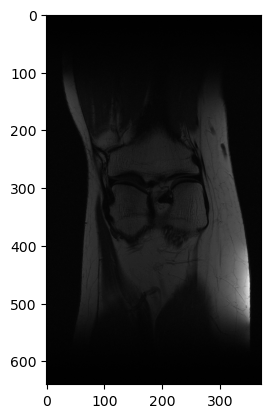

In [5]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from fastmri.data import transforms as T

file_name = '/cheng/metaMRI/metaMRI/data_dict/test1_knee/file1000496.h5'
hf = h5py.File(file_name)
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


In [6]:
file_name = '/cheng/metaMRI/metaMRI/output/reconstructions/file1000496.h5'
hf = h5py.File(file_name)
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

KeyError: "Unable to open object (object 'kspace' doesn't exist)"

In [7]:
file_name = '/cheng/metaMRI/metaMRI/output/reconstructions/file1000496.h5'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['reconstruction']
Attrs: {}
